In [89]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
import itertools
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [10]:
# Logic to save audio to file
import scipy
import scipy.io.wavfile

def write_audio_file(filename, filedata, sample_rate):
    scipy.io.wavfile.write(filename, sample_rate, filedata)

# FSK modem research 2

Continuing from `fsk_modem_research`, let's now try to see if we can demodulate and modulate a real signal: [APRS](https://en.wikipedia.org/wiki/Automatic_Packet_Reporting_System).

The nice thing about APRS is that:
* It is a network available almost everywhere in the US
* It is AFSK, so you can simply work with audio files. So to transmit, you just play the modulated audio file, and use a headphone jack to pipe it to a radio to transmit it.

I recorded a couple samples of the same APRS signal. I'm going to try to demodulate it (audio -> bits), and then remodulate it (bits -> audio).


### Received APRS packet

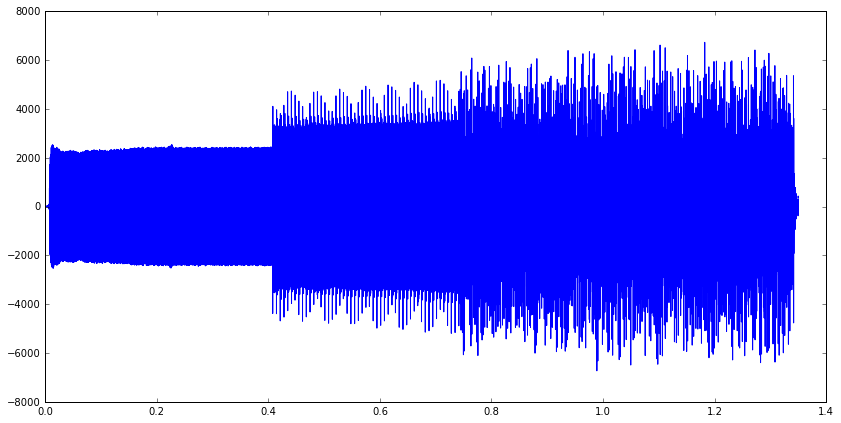

In [8]:
(aprs1_sample_rate, aprs1_input_signal) = scipy.io.wavfile.read("raw_data/aprs_pocket_packet.wav")
time_array = np.arange(0, len(aprs1_input_signal)/aprs1_sample_rate, 1/aprs1_sample_rate)
setup_graph(fig_size=(14,7))
_ = plt.plot(time_array, aprs1_input_signal)

In [11]:
Audio(aprs1_input_signal, rate=44700)

Well, it certainly sounds like there's some type of preamble before the actual data. I wonder what it is...

#### Let's visualize this signal with a spectrogram

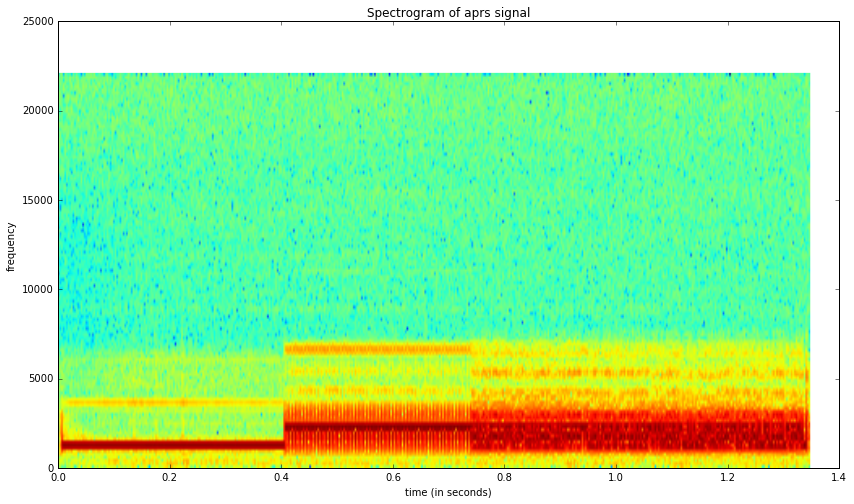

In [12]:
setup_graph(title='Spectrogram of aprs signal', x_label='time (in seconds)', y_label='frequency', fig_size=(14,8))
_ = plt.specgram(aprs1_input_signal, Fs=44100)

#### And let's zoom in with downsampling

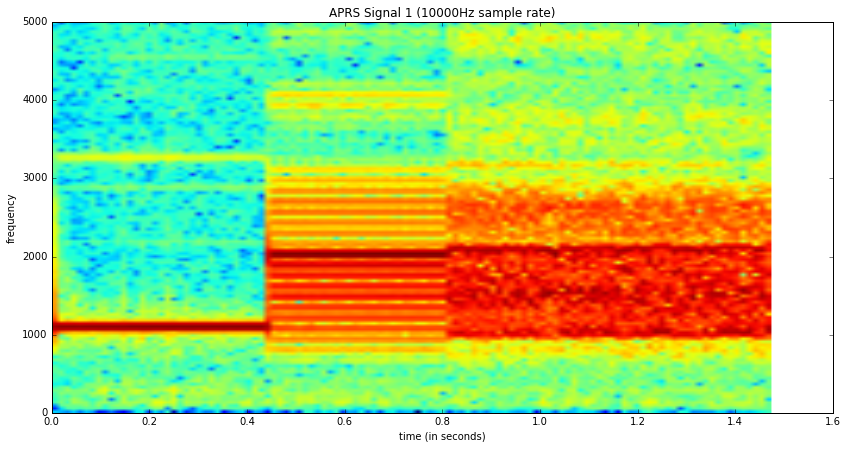

In [13]:
aprs1_10000hz = [aprs1_input_signal[i] for i in range(0, len(aprs1_input_signal), 44100//10000)]
setup_graph(title='APRS Signal 1 (10000Hz sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(aprs1_10000hz, Fs=10000)

### Interpreting

The Bell 202 protocol (which APRS uses) is supposed to use:
* 1200 Hz tone for mark (typically a binary 1)
* 2200 Hz for space (typically a binary 0)
* 1200 baud

It can be seen in the spectrogram that the signal starts off right about 1000 Hz, and it looks like it transitions to right about 2000 Hz, and then sends the modulated data. It looks like this preamble lasts for about 0.8 seconds.

Just estimating... It looks like about 0.8 to 1.45 seconds is the data. So how much data is that?

In [194]:
data_time = 1.45-0.8
num_bits = data_time * 1200  # baud
num_bytes = num_bits / 8
num_bytes

97.49999999999999

So the actual message is around 98 bytes, which seems about right.

Now let's try to demodulate it!

### Demodulate captured APRS signal

Let's start with the generic `fsk_demodulate` function developed in `fsk_modem_research.ipynb`...

In [197]:
def fsk_demodulate(raw_signal, bit_freq_map, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    
    # maps from bit sequence (like "10") to the modulated wave representing that "symbol"
    wave_to_symbol_map = {bit_seq: np.sin(freq * 2 * np.pi * t) for bit_seq, freq in bit_freq_map.items()}
    
    bit_str = ""
    for index in range(0, len(raw_signal), samples_per_bit):
        best_symbol = ""
        highest_dot_abs = 0
        for symbol, symbol_wave in wave_to_symbol_map.items():
            raw_window = raw_signal[index:index+samples_per_bit]
            dot_abs = np.abs(np.dot(symbol_wave[0:len(raw_window)], raw_window))
            if dot_abs > highest_dot_abs:
                best_symbol = symbol
                highest_dot_abs = dot_abs
        bit_str += best_symbol
    return bit_str

In [198]:
(sample_rate, captured_aprs_signal) = scipy.io.wavfile.read("raw_data/aprs_pocket_packet.wav")
demodulated_captured_aprs_msg = fsk_demodulate(captured_aprs_signal, {"0": 2200, "1": 1200}, 1200, sample_rate)
demodulated_captured_aprs_msg

'001100101011111110111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111001111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111011111111111111111111111101111111111111111111111100111111111111111111111110111111111111111111111110011111111111111111111111011111111111111111111111101111111111111110000000100100001100000010000000100000000000100001000000001000000100000001000000010000000000000000000000001000000010100000100000000000010010000000110100001100000001000010010000000110000001000000011000010010000000100100001100000010000010100000000100100001000000011000010100000001000100000000000011000000000000001000000010000000100000000000000000000000010000000100000001000000010000000110100001100000011000010010000101111011011011100111000100110110111010010101110101010001111101101001100000011000101001

The first thing I notice is that what I expected to be a continuous string of '1's actually has some '0's in it... although, after the first 8 or so (which is probably noise since the signal is not perfectly cropped), they seem regularly spaced. But I wonder if there is error in this.

I'm going to try to record that signal again, and see try to demodulate it again...

In [199]:
(sample_rate2, captured_aprs_signal2) = scipy.io.wavfile.read("raw_data/aprs_pocket_packet2.wav")
demodulated_captured_aprs_msg2 = fsk_demodulate(captured_aprs_signal2, {"0": 2200, "1": 1200}, 1200, sample_rate2)
demodulated_captured_aprs_msg2

'001000101011111110111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111001111111111111111111111101111111111111111111111110111111111111111111111110111111111111111111111111011111111111111111111111011111111111111111111111101111111111111111111111100111111111111111111111110111111111111111111111110011111111111111111111111011111111111111111111111101111111111111110000000100100001100000010000000100000000000100001000000001000000100000001000000010000000000000000000000001000000010100000100000000000010010000000110100001100000001000010010000000110000001000000011000010010000000100100001100000010000010100000000100100001000000011000010100000001000100000000000011000000000000001000000010000000100000000000000000000000010000000100000001000000010000000110100001100000011000010010000101111011011011100111000100110110111010010101110101010001111101101001100000011000101001

Wow! So it looks almost exactly the same. Maybe there are not errors after all. Are they exactly the same?

In [200]:
len(demodulated_captured_aprs_msg) == len(demodulated_captured_aprs_msg2)

True

In [201]:
demodulated_captured_aprs_msg == demodulated_captured_aprs_msg2

False

Nope. Well, at least I know I didn't accidentally do the same exact recording. So if there are any errors other than cropping errors, at least thing look very close to correct.

In [202]:
index_mismatches = []

for index in range(len(demodulated_captured_aprs_msg)):
    if demodulated_captured_aprs_msg[index] != demodulated_captured_aprs_msg2[index]:
        index_mismatches.append(index)

index_mismatches

[3]

Oh good, looks like it's only off in one spot, and it's in the beginning, which may be a cropping error.

Let's go ahead and try to remodulate it...

## APRS Modulation

Let's start off witht he `fsk_modulate` function developed in part 1...

In [205]:
def fsk_modulate(bit_str, bit_freq_map, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    
    # maps from bit sequence (like "10") to the modulated wave representing that "symbol"
    symbol_map = {bit_seq: np.sin(freq * 2 * np.pi * t) for bit_seq, freq in bit_freq_map.items()}

    signal = np.array([])
    bits_per_symbol = len(list(bit_freq_map.keys())[0])  # Assume all keys are the same length
    for symbol in [bit_str[i:i+bits_per_symbol] for i in range(0, len(bit_str), bits_per_symbol)]:
        symbol_wave = symbol_map[symbol]
        signal = np.append(signal, symbol_wave)
    return signal

In [209]:
remodulated_aprs_msg = fsk_modulate(demodulated_captured_aprs_msg, {"0": 2200, "1": 1200}, 1200, 44100)

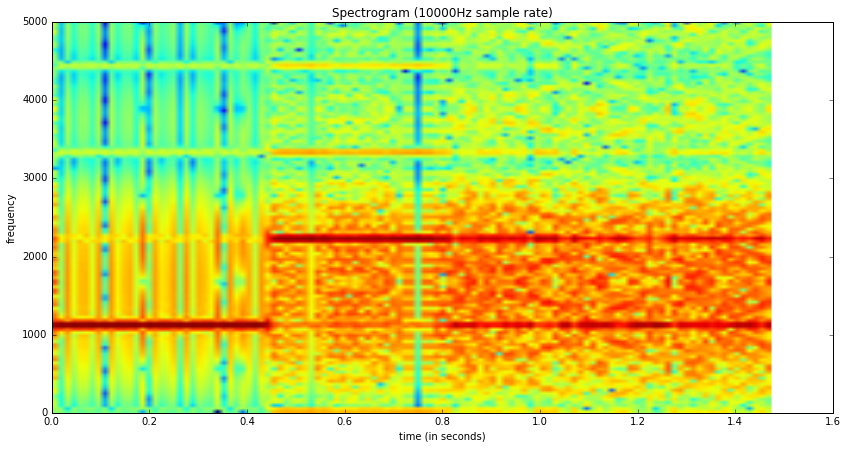

In [210]:
remodulated_10000hz = [remodulated_aprs_msg[i] for i in range(0, len(remodulated_aprs_msg), 44100//10000)]
setup_graph(title='Spectrogram (10000Hz sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(remodulated_10000hz, Fs=10000)

In [211]:
Audio(remodulated_aprs_msg, rate=44100)

Hmmmm, it sounds overmodulated and does not work when broadcasted over the radio...

Perhaps there's a problem with the modulation algorithm. Let's compare the generated with captured signals...

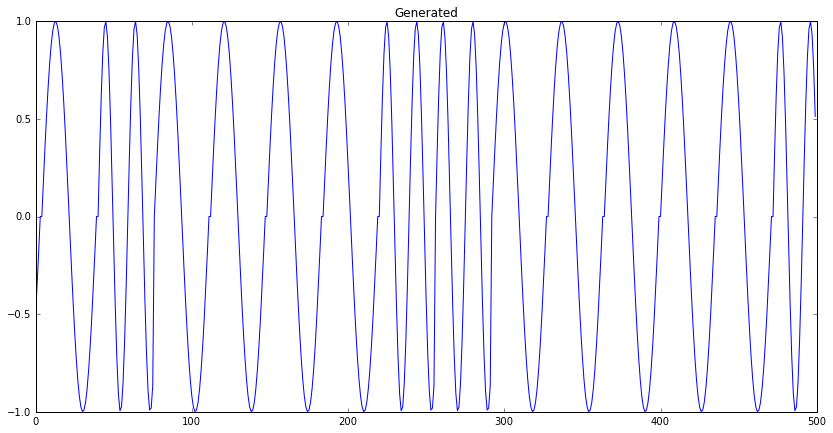

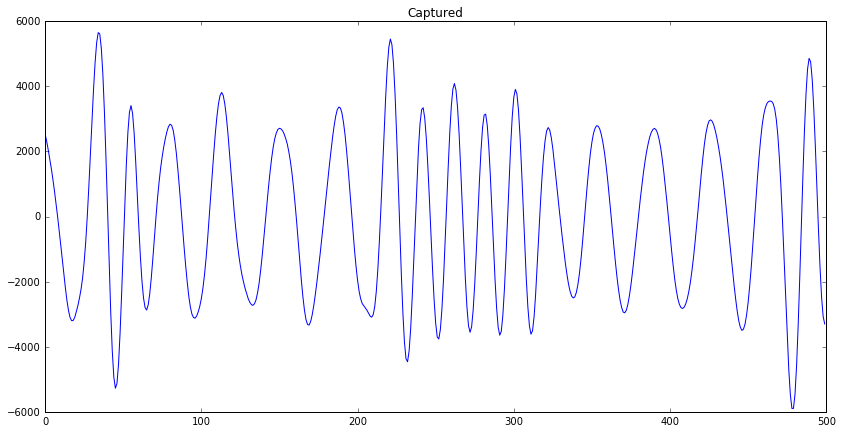

In [227]:
setup_graph(title='Generated', fig_size=(14,7))
_ = plt.plot(remodulated_aprs_msg[50000:50500])

setup_graph(title='Captured', fig_size=(14,7))
_ = plt.plot(captured_aprs_signal[50000:50500])

It actually looks like we may not be getting full wave cycles for each bit, meaning my idea of just generating full wave cycles and concatenating them may not work, since the phases may not line up. Let's test this...

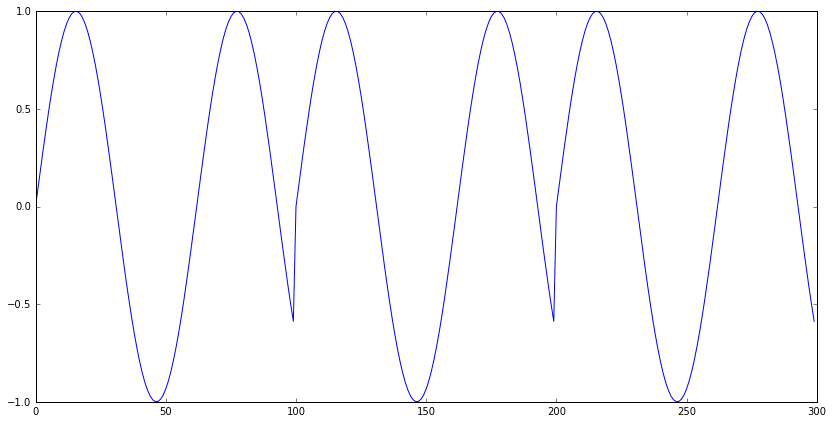

In [228]:
seconds_per_bit = 1/10
sample_rate = 1000
freq = 16
samples_per_bit = seconds_per_bit * sample_rate
t = np.linspace(0, seconds_per_bit, samples_per_bit)
y = np.sin(freq*2*np.pi*t)
setup_graph(fig_size=(14,7))

y_repeated = np.array([])
for i in range(3):
    y_repeated = np.append(y_repeated, y)
_ = plt.plot(y_repeated)

I had an idea to just stretch the time a bit longer, but then I looked at the captured APRS signal up close:
    
![APRS up close](images/aprs_close.png)

(Note that on the left is part of the preamble, and on the right are the actual bits)

So I had the idea to just modify the time slightly so that the wave phases line up - so that we don't get a choppy sounding signal. However, I realized that there is no room for modifying the time so the phases line up with APRS, because there are very few cycles of the wave for each bit. The reason is that APRS uses a baud of 1200 and a frequency of 1200 (for 0) - that means that for a binary 0, there is only one cycle of the wave, and for 1, there isn't quite room for 2 cycles. This can be seen when looking at the signal up close:

**So ultimately, my idea of having full phase waves only for each "bit" won't quite work.**

## Continuous time approach

So that leads me to doing the modulation more like real radios do it: rather than trying to create small waves to represent "0" and "1" and then appending them to each other, I need to just create 1 wave to represent the entire transmission, and change the frequency between 1200 and 2200 inside of this one wave.

In [236]:
def fsk_modulate2(bit_str, bit_freq_map, baud, sample_rate):
    num_bits = len(bit_str)
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    bits_per_symbol = len(list(bit_freq_map.keys())[0])  # Assume all keys are the same length

    time_diff_between_samples = seconds_per_bit/samples_per_bit
    signal = np.array([])
    time_in_signal = 0
    for symbol in [bit_str[i:i+bits_per_symbol] for i in range(0, len(bit_str), bits_per_symbol)]:
        freq = bit_freq_map[symbol]
        t = np.linspace(time_in_signal, time_in_signal+seconds_per_bit, samples_per_bit)
        time_in_signal += seconds_per_bit
        symbol_wave = 0.2 * np.sin(freq * 2 * np.pi * t)
        signal = np.append(signal, symbol_wave)
        time_in_signal += time_diff_between_samples

    return signal

In [237]:
remodulated_aprs_msg2 = fsk_modulate2(demodulated_captured_aprs_msg, {"0": 2200, "1": 1200}, 1200, 44100)

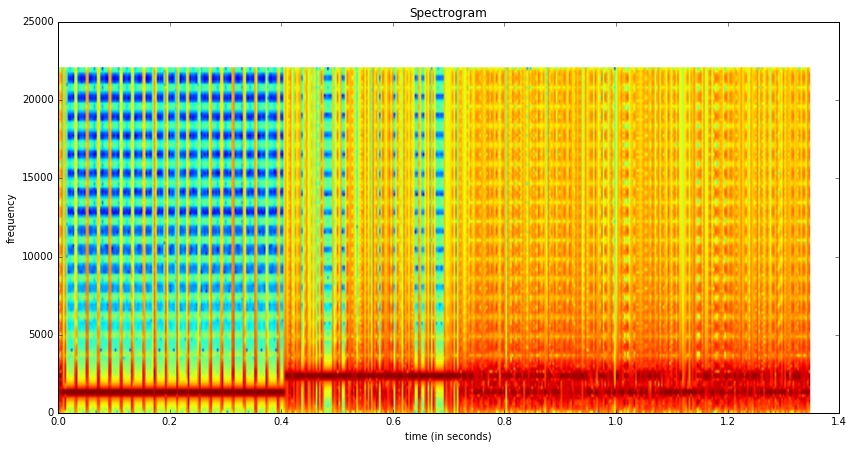

In [238]:
setup_graph(title='Spectrogram', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(remodulated_aprs_msg2, Fs=44100)

In [239]:
Audio(remodulated_aprs_msg2, rate=44100)

Oh, that is horrible! Let's try a different approach...

In [241]:
def get_time_sample_points(num_bits, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    seconds_per_sample = seconds_per_bit / samples_per_bit
    
    t = 0
    
    for sample_point in range(num_bits * int(samples_per_bit)):
        yield t
        t += seconds_per_sample

def fsk_modulate3(bit_str, bit_freq_map, baud, sample_rate):
    num_bits = len(bit_str)
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    bits_per_symbol = len(list(bit_freq_map.keys())[0])  # Assume all keys are the same length
    
    clock = get_time_sample_points(num_bits, baud, sample_rate)

    time_diff_between_samples = seconds_per_bit/samples_per_bit + .0001
    signal = np.array([])
    for symbol in [bit_str[i:i+bits_per_symbol] for i in range(0, len(bit_str), bits_per_symbol)]:
        freq = bit_freq_map[symbol]
        t = np.array(list(itertools.islice(clock, samples_per_bit)))
        symbol_wave = 0.2 * np.sin(freq * 2 * np.pi * t)
        signal = np.append(signal, symbol_wave)
    return signal

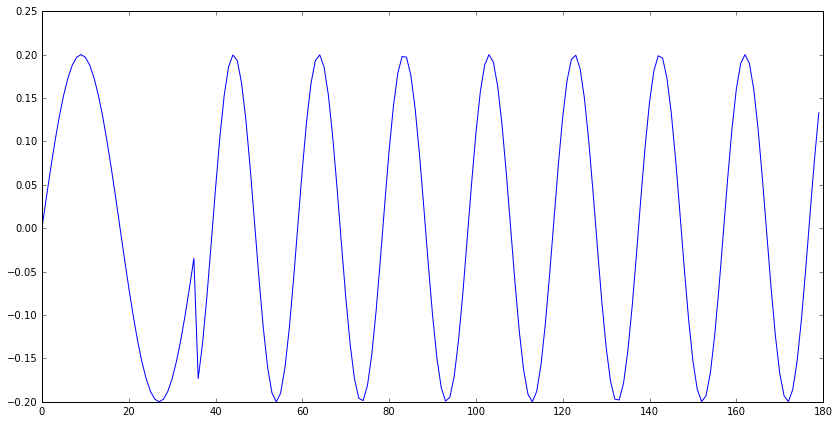

In [243]:
test_modulate = fsk_modulate("10000", {"0": 2200, "1": 1200}, 1200, 44100)

# Time-domain plot
setup_graph(fig_size=(14,7))
_ = plt.plot(test_modulate)

### Need a phase-shift

Ah ha!

I found the problem - it looks like I've been relying on the phase of the sine wave staying the same, but the phase is different when shifting frequency!

So I need to align the phases between phase shifts.

In [244]:
def get_phase_shift(freq_from, freq_to, current_time, previous_phase_shift):
    if freq_from == freq_to:
        return 0
    return (freq_from * 2 * np.pi * current_time + previous_phase_shift) - (freq_to * 2 * np.pi * current_time)

def fsk_modulate4(bit_str, bit_freq_map, baud, sample_rate):
    num_bits = len(bit_str)
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    bits_per_symbol = len(list(bit_freq_map.keys())[0])  # Assume all keys are the same length
    
    clock = get_time_sample_points(num_bits, baud, sample_rate)

    freq = None
    previous_freq = None
    phase_shift = 0
    previous_phase_shift = 0
    t = np.array([0])
    previous_t = 0
    signal = np.array([])
    
    for symbol in [bit_str[i:i+bits_per_symbol] for i in range(0, len(bit_str), bits_per_symbol)]:
        if freq is not None:
            previous_freq = freq
        else:
            previous_freq = bit_freq_map[symbol]

        freq = bit_freq_map[symbol]
        
        previous_t = t[-1]
        t = np.array(list(itertools.islice(clock, samples_per_bit)))
        
        if previous_freq != freq:
            previous_phase_shift = phase_shift
            phase_shift = get_phase_shift(previous_freq, freq, previous_t, previous_phase_shift)
        
        symbol_wave = 0.2 * np.sin(freq * 2 * np.pi * t + phase_shift)
        signal = np.append(signal, symbol_wave)
    return signal

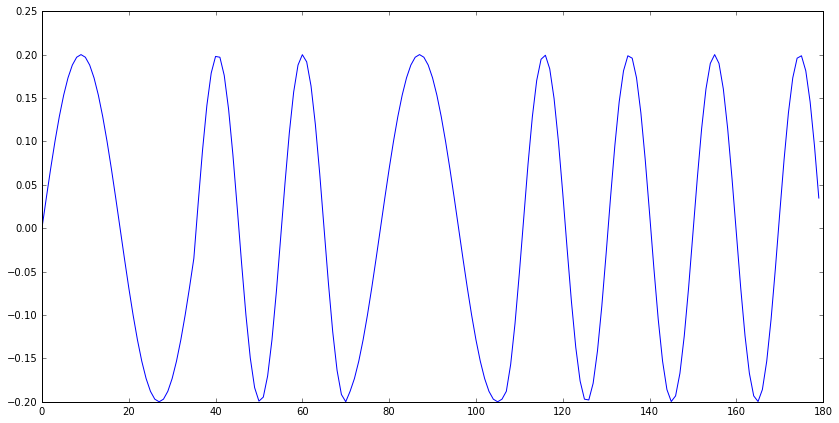

In [246]:
test_modulate = fsk_modulate4("10100", {"0": 2200, "1": 1200}, 1200, 44100)

# Time-domain plot
setup_graph(fig_size=(14,7))
_ = plt.plot(test_modulate)

### Success

That looks perfect - no phase issues between frequency shifts. Now let's try it with the APRS signal...

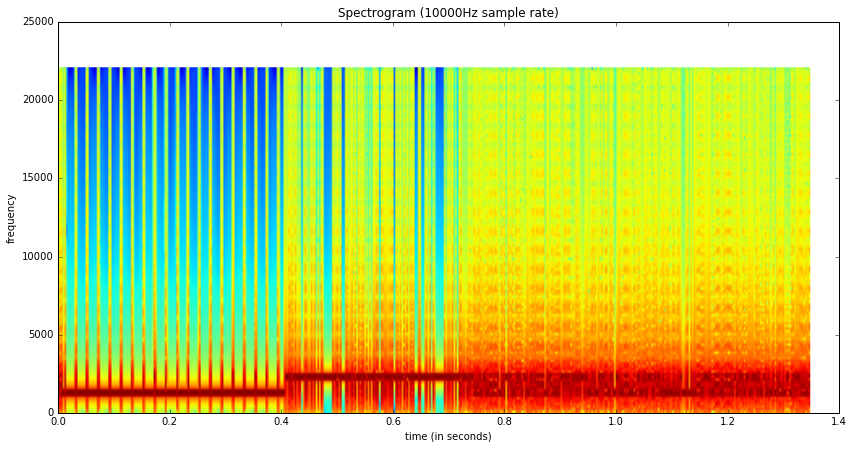

In [250]:
cleaned_signal = '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000011000000110000100100001011110110110111001110001001101101110100101011101010100011111011010011000000110001010011011100101001001001011100000110011111010010010110011010010010101000101111101110010001010111011011011010110000010010010001000100110001000100110011001100000011000011100111011110110011101111100001001000011010101111001100010111111100000111011101110101001010101111110111010111100010011110011100111001100001000011001100011010001110111011001110111110111011110110110111101111000011111111011110111111011110011111010101010110110001100000011001100111011001010100101110110011010101001010010101101100001101011100110000101110100000111001111000001001001110011101110000110111011001111110100111100110111010111110111100010001111011010000110011000100101110111011101110010101'
remodulated_aprs_msg = fsk_modulate4(demodulated_captured_aprs_msg, {"0": 2200,"1": 1200}, 1200, 44100)
setup_graph(title='Spectrogram (10000Hz sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(remodulated_aprs_msg, Fs=44100)

In [251]:
Audio(remodulated_aprs_msg, rate=44100)

It sounds nice too. Let's see what it looks like in audacity...

In [249]:
write_audio_file('raw_data/remodulated_test_44100.wav', remodulated_aprs_msg, 44100)

![remodulated signal](images/remodulated_aprs_signal_phase_good.png)

And that looks nice too.

I notice the preamble looks bad. I wonder if that part should not be run through the demodulation algorithm. I'll see what it looks like if I try changing the preamble to pure waves...

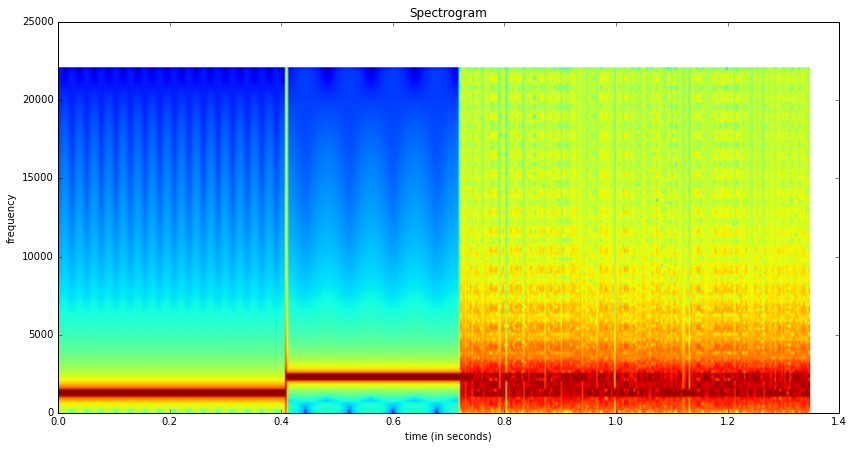

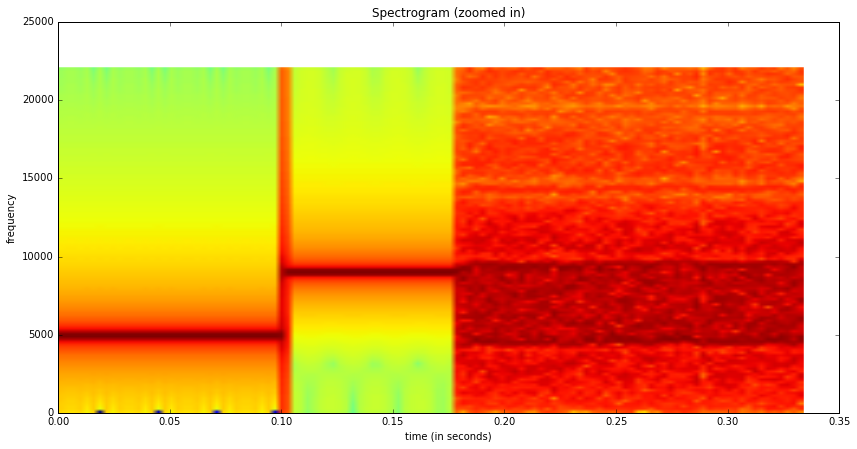

In [255]:
cleaned_signal = '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000011000000110000100100001011110110110111001110001001101101110100101011101010100011111011010011000000110001010011011100101001001001011100000110011111010010010110011010010010101000101111101110010001010111011011011010110000010010010001000100110001000100110011001100000011000011100111011110110011101111100001001000011010101111001100010111111100000111011101110101001010101111110111010111100010011110011100111001100001000011001100011010001110111011001110111110111011110110110111101111000011111111011110111111011110011111010101010110110001100000011001100111011001010100101110110011010101001010010101101100001101011100110000101110100000111001111000001001001110011101110000110111011001111110100111100110111010111110111100010001111011010000110011000100101110111011101110010101'
remodulated_aprs_msg_cleaned = fsk_modulate4(cleaned_signal, {"0": 2200,"1": 1200}, 1200, 44100)
setup_graph(title='Spectrogram', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(remodulated_aprs_msg_cleaned, Fs=44100)

remodulated_aprs_msg_cleaned_zoomed_in = [remodulated_aprs_msg_cleaned[i] for i in range(0, len(remodulated_aprs_msg_cleaned), 44100//10000)]

setup_graph(title='Spectrogram (zoomed in)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(remodulated_aprs_msg_cleaned_zoomed_in, Fs=44100)

In [253]:
Audio(remodulated_aprs_msg_cleaned, rate=44100)

### Preamble

That looks and sounds pretty close to the original. So what is the preamble exactly?

![preamble](images/preamble_audacity.png)

So the first part is clearly a pure sine wave (looks like at 1200Hz). But what is the second part? It kind of looks like it's modulating some signal like `111111101111111011111110`, or something like that.

Let's do a Fourier Transform of it.

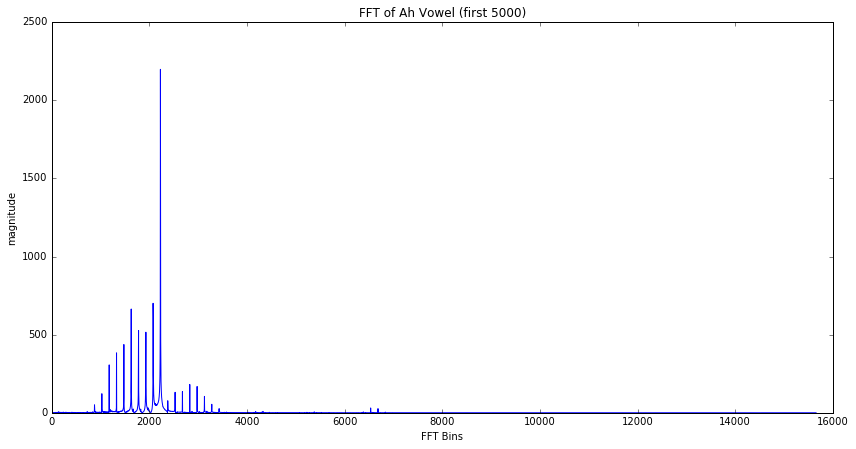

In [259]:
(sample_rate, input_signal) = scipy.io.wavfile.read("raw_data/preamble_part_2.wav")

fft_out = np.fft.rfft(input_signal)
fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
num_samples = len(input_signal)
rfreqs = [(i*1.0/num_samples)*sample_rate for i in range(num_samples//2+1)]

setup_graph(title='FFT of Ah Vowel (first 5000)', x_label='FFT Bins', y_label='magnitude', fig_size=(14,7))
_ = plt.plot(rfreqs[0:5000], fft_mag[0:5000])

Huh... Not sure what that is. Maybe FFTs don't work well on signals that are completely shifting (modulating), and maybe the second part is just something like `10000000100000001000000010000000`.